Import des fichiers dans google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import des librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, BaggingClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from imblearn.metrics import classification_report_imbalanced

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Import DataFrame pour modélisation
df = pd.read_csv('/content/df_model.csv', index_col=0)

# La saison lue en tant que numérique est remise en chaine de caractère
df['Saison'] = df['Saison'].astype(str)

# Sélection de variables

Corrélation des variables entre elles et avec le résultat du match

In [4]:
df_complet = df.copy()
df_complet['Resultat_match'] = df_complet['Resultat_match'].replace(['H','D','A'], [2, 1,0])
df_complet.corr()

Resultat_match  ...  Res_an_dernier_H
Resultat_match                         1.000000  ...          0.079533
Moy_cote_domicile                     -0.316128  ...         -0.133929
Max_cote_domicile                     -0.305735  ...         -0.129895
Min_cote_domicile                     -0.323177  ...         -0.139209
Moy_cote_exterieur                     0.287663  ...          0.181058
Max_cote_exterieur                     0.267276  ...          0.164760
Min_cote_exterieur                     0.303760  ...          0.205087
Moy_cote_nul                           0.133529  ...          0.151283
Max_cote_nul                           0.136498  ...          0.144790
Min_cote_nul                           0.128379  ...          0.161562
Nb_buts_equipe_dom_an_dernier          0.064225  ...          0.744862
Nb_buts_equipe_ext_an_dernier         -0.083655  ...         -0.113253
Num_match_dom                         -0.015986  ...          0.002486
Moy_points_5_match_dom                 0.159726  ...          0.128686
Moy_buts_5_matchs_dom                  0.179866  ...          0.137580
Moy_tirs_cadres_5_matchs_dom           0.179153  ...          0.147169
Moy_tirs_5_matchs_dom                  0.158741  ...          0.146071
Nb_jours_dernier_match_dom            -0.038109  ...          0.006649
Moy_nb_fautes_5_matchs_dom            -0.029702  ...         -0.084356
Moy_corners_5_matchs_dom               0.123493  ...          0.098388
Moy_carton_J_5_matchs_dom              0.008185  ...         -0.008544
Moy_carton_R_5_matchs_dom             -0.008923  ...         -0.063993
Num_match_ext                         -0.015668  ...          0.002997
Moy_points_5_match_ext                -0.139063  ...         -0.020270
Moy_buts_5_matchs_ext                 -0.146674  ...         -0.019273
Moy_tirs_cadres_5_matchs_ext          -0.128817  ...         -0.005199
Moy_tirs_5_matchs_ext                 -0.120794  ...          0.029888
Nb_jours_dernier_match_ext            -0.044709  ...          0.003104
Moy_nb_fautes_5_matchs_ext             0.032632  ...         -0.019396
Moy_corners_5_matchs_ext              -0.096827  ...          0.007344
Moy_carton_J_5_matchs_ext              0.021042  ...         -0.034244
Moy_carton_R_5_matchs_ext             -0.002225  ...         -0.030862
Points_moy_match_saison_dom            0.182228  ...          0.140237
Points_moy_match_saison_ext           -0.170919  ...         -0.042246
Pct_buts_par_tirs_cadres_5m_dom        0.089577  ...          0.057673
Pct_buts_par_tirs_cadres_5m_ext       -0.082664  ...         -0.022992
note_att_dom                           0.246068  ...          0.249991
note_mil_dom                           0.253378  ...          0.278336
note_def_dom                           0.247336  ...          0.258537
note_gen_dom                           0.253553  ...          0.273694
note_att_ext                          -0.239922  ...         -0.035764
note_mil_ext                          -0.267816  ...         -0.018424
note_def_ext                          -0.283858  ...         -0.004345
note_gen_ext                          -0.282362  ...         -0.017398
Res_an_dernier_A                      -0.084498  ...         -0.281773
Res_an_dernier_D                      -0.028601  ...         -0.274820
Res_an_dernier_H                       0.079533  ...          1.000000

[47 rows x 47 columns]

Les cotes à domicile sont très corrélées entre elles, on ne garde que celle qui est la plus corrélée avec le résultat du match : Min_cote_domicile.

Idem pour les cotes à l'extérieur et nul, on ne garde que Min_cote_exterieur et Max_cote_nul.

Les notes défense, milieu, attaque sont assez corrélées aussi, on garde note_def_ext et note_gen_dom.

Le coefficient de cartons rouges sur 5 matches à l'extérieur est très proche de 0, nous allons donc supprimer cette variable.
Idem pour Moy_nb_fautes_5_matchs_dom, Moy_carton_J_5_matchs_dom, Moy_carton_R_5_matchs_dom, Moy_nb_fautes_5_matchs_ext,	Moy_corners_5_matchs_ext, Moy_carton_J_5_matchs_ext, Pct_buts_par_tirs_cadres_5m_dom, Pct_buts_par_tirs_cadres_5m_ext, Num_match_ext, Num_match_dom, Nb_jours_dernier_match_dom, Nb_jours_dernier_match_ext.

In [5]:
# Suppression des variables corrélées
to_drop = [ 'Moy_cote_domicile', 'Max_cote_domicile','Moy_cote_exterieur','Max_cote_exterieur','Moy_cote_nul','Min_cote_nul','note_att_dom','note_mil_dom','note_def_dom','note_att_ext', 'note_mil_ext', 'note_gen_ext',
  'Moy_carton_R_5_matchs_ext','Moy_nb_fautes_5_matchs_dom', 'Moy_carton_J_5_matchs_dom','Moy_carton_R_5_matchs_dom','Moy_nb_fautes_5_matchs_ext',
   'Moy_corners_5_matchs_ext', 'Moy_carton_J_5_matchs_ext','Res_an_dernier_A','Res_an_dernier_H','Res_an_dernier_D','Pct_buts_par_tirs_cadres_5m_dom',
   'Pct_buts_par_tirs_cadres_5m_ext','Num_match_ext','Num_match_dom','Nb_jours_dernier_match_dom','Nb_jours_dernier_match_ext']
df.drop(to_drop, axis = 1, inplace = True)

In [6]:
# Création des dataframes de cible et de données
target = df[['Resultat_match','Saison']]
data=df.drop(['Resultat_match'],axis=1)

# Remplacement des modalités de target par des nombres pour la modélisation
target['Resultat_match'] = target['Resultat_match'].replace(['H','D','A'], [2, 1,0])

# Création des dataframes d'entraînement et de test : entraînement sur les saisons 2015 à 2020 et test sur 2021 (saison non encore terminée)
X_train_ = data.loc[data['Saison'] != '2021', :].drop('Saison',axis=1)
X_test_ = data.loc[data['Saison'] == '2021', :].drop('Saison',axis=1)
y_train = target.loc[target['Saison'] != '2021', :].drop('Saison',axis=1)
y_test = target.loc[target['Saison'] == '2021', :].drop('Saison',axis=1)
print(X_train_.shape)
print(X_test_.shape)
print(y_train.shape)
print(y_test.shape)

# Standardisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_)
X_test = scaler.transform(X_test_)

y_test = y_test.to_numpy().reshape(220,)
y_train = y_train.to_numpy().reshape(2178,)

(2178, 18)
(220, 18)
(2178, 1)
(220, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Pourcentage de matchs par résultat

In [7]:
# Train
df_y_train=pd.DataFrame(y_train, columns=['Resultat_match'])
print("% de matchs par résultat sur l'échantillon d'entrainement")
display(df_y_train.Resultat_match.value_counts(normalize=True).to_frame())

# Test
df_y_test=pd.DataFrame(y_test, columns=['Resultat_match'])
print("% de matchs par résultat sur l'échantillon de test")
display(df_y_test.Resultat_match.value_counts(normalize=True).to_frame())

% de matchs par résultat sur l'échantillon d'entrainement


Resultat_match
2        0.440312
0        0.296602
1        0.263085

% de matchs par résultat sur l'échantillon de test


Resultat_match
2        0.413636
0        0.300000
1        0.286364

Le résultat le plus courant est la victoire à domicile (44% sur l'échantillon d'entrainement et 41,3 % su l'échantillon de test. 

Notre modèle devra avoir un pourcentage de bonne modélisation au moins supérieur à 41,3 % pour avoir un intérêt par rapport à miser toujours sur la victoire de l'équipe à domicile.

# SVM

Accuracy:  0.4727272727272727


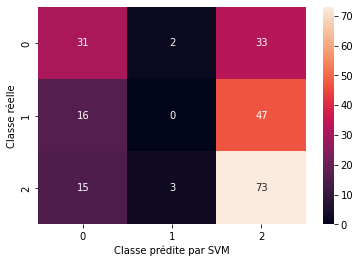

In [8]:
# Modèle SVM avec les paramètres par défaut
svm = svm.SVC()
svm.fit(X_train, y_train)

# Matrice de confusion et scores
y_pred_svm = svm.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred_svm, rownames = ['Classe réelle'], colnames = ['Classe prédite par SVM'])
sns.heatmap(confusion_matrix, annot = True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_svm));

In [9]:
# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_svm)) 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      0.47      0.80      0.48      0.61      0.36        66
          1       0.00      0.00      0.97      0.00      0.00      0.00        63
          2       0.48      0.80      0.38      0.60      0.55      0.32        91

avg / total       0.35      0.47      0.67      0.39      0.41      0.24       220



In [10]:
# Modèle SVM avec un Grid Search
param_svm = {'C':[0.1,1,10], 'kernel':['rbf','linear', 'poly'], 'gamma':[0.001, 0.1, 0.5]}

grid_svm = GridSearchCV(estimator=svm, param_grid=param_svm)
grid_svm.fit(X_train,y_train)

# Meilleurs paramètres
print(grid_svm.best_params_)

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


Accuracy:  0.4727272727272727


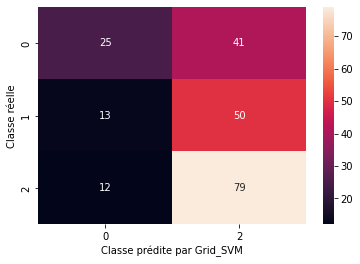

In [11]:
# Matrice de confusion et scores
y_pred_grid_svm = grid_svm.predict(X_test)
confusion_matrix = pd.crosstab(y_test,y_pred_grid_svm, rownames = ['Classe réelle'], colnames = ['Classe prédite par Grid_SVM'])
sns.heatmap(confusion_matrix, annot = True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_grid_svm))

Le score est le même qu'avec les paramètres par défaut

In [12]:
# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_grid_svm)) 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      0.38      0.84      0.43      0.56      0.30        66
          1       0.00      0.00      1.00      0.00      0.00      0.00        63
          2       0.46      0.87      0.29      0.61      0.51      0.27        91

avg / total       0.34      0.47      0.66      0.38      0.38      0.20       220



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Random Forest

Accuracy:  0.4590909090909091


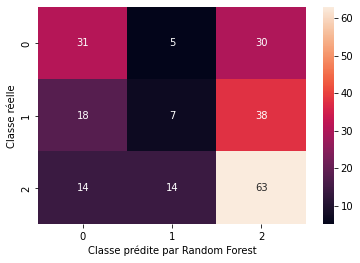

In [13]:
# Modèle Random Forest avec les paramètres par défaut
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Matrice de confusion et scores
y_pred_rf = rf.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred_rf, rownames = ['Classe réelle'], colnames = ['Classe prédite par Random Forest'])
sns.heatmap(confusion_matrix, annot = True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_rf));

Score changeant à chaque compilation (compris entre 0.43 et 0.49)

In [14]:
# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_rf)) 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.49      0.47      0.79      0.48      0.61      0.36        66
          1       0.27      0.11      0.88      0.16      0.31      0.09        63
          2       0.48      0.69      0.47      0.57      0.57      0.33        91

avg / total       0.42      0.46      0.68      0.42      0.51      0.27       220



In [15]:
# Modèle Random Forest avec Grid Search 

param_rf = {'max_features': ["sqrt", "log2" ], 'min_samples_split': range(2, 60, 3)}

grid_rf = GridSearchCV(estimator = rf, param_grid = param_rf)
grid_rf.fit(X_train, y_train)

# Meilleurs paramètres
print(grid_rf.best_params_)

{'max_features': 'log2', 'min_samples_split': 56}


Accuracy:  0.4681818181818182


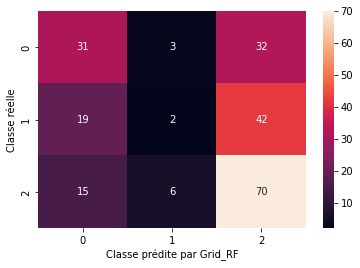

In [16]:
# Matrice de confusion et scores
y_pred_grid_rf = grid_rf.predict(X_test)
confusion_matrix = pd.crosstab(y_test,y_pred_grid_rf, rownames = ['Classe réelle'], colnames = ['Classe prédite par Grid_RF'])
sns.heatmap(confusion_matrix, annot = True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_grid_rf));

In [17]:
# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_grid_rf)) 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.48      0.47      0.78      0.47      0.60      0.35        66
          1       0.18      0.03      0.94      0.05      0.17      0.03        63
          2       0.49      0.77      0.43      0.60      0.57      0.34        91

avg / total       0.40      0.47      0.68      0.40      0.47      0.25       220



Les résultats sont mauvais surtout pour modéliser les matchs nuls (modalité 1)

# KNN

Accuracy:  0.4


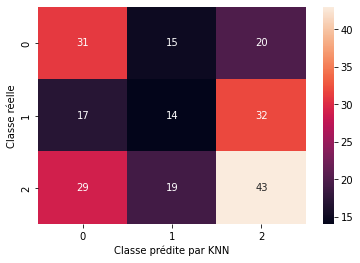

In [18]:
# Modèle KNN avec les paramètres par défaut
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Matrice de confusion et scores
y_pred_knn = knn.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred_knn, rownames = ['Classe réelle'], colnames = ['Classe prédite par KNN'])
sns.heatmap(confusion_matrix, annot = True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_knn));

Le score est inférieur à SVM et à miser toujours sur une victoire à domicile.

In [19]:
# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_knn)) 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.40      0.47      0.70      0.43      0.57      0.32        66
          1       0.29      0.22      0.78      0.25      0.42      0.16        63
          2       0.45      0.47      0.60      0.46      0.53      0.28        91

avg / total       0.39      0.40      0.68      0.39      0.51      0.26       220



In [20]:
# Modèle KNN avec GridSearch

param_knn = {'n_neighbors' : [k for k in range(5,60,5)],
                  'weights' : ['uniform', 'distance'],
                 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                 'metric' : ['minkowski', 'manhattan', 'chebyshev', 'euclidean']}

grid_knn = GridSearchCV(estimator = knn, param_grid = param_knn)
grid_knn.fit(X_train, y_train)

# Meilleurs paramètres
print(grid_knn.best_params_)

{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 55, 'weights': 'distance'}


Accuracy:  0.4727272727272727


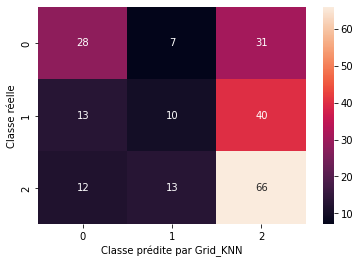

In [21]:
# Matrice de confusion et scores
y_pred_grid_knn = grid_knn.predict(X_test)
confusion_matrix = pd.crosstab(y_test,y_pred_grid_knn, rownames = ['Classe réelle'], colnames = ['Classe prédite par Grid_KNN'])
sns.heatmap(confusion_matrix, annot = True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_grid_knn));

Score identique au SVM

In [22]:
# Rapport de classification
print(classification_report_imbalanced(y_test, y_pred_grid_knn)) 

                   pre       rec       spe        f1       geo       iba       sup

          0       0.53      0.42      0.84      0.47      0.60      0.34        66
          1       0.33      0.16      0.87      0.22      0.37      0.13        63
          2       0.48      0.73      0.45      0.58      0.57      0.34        91

avg / total       0.45      0.47      0.69      0.44      0.52      0.28       220



# Bagging

In [23]:
bc = BaggingClassifier(n_estimators = 1000, oob_score = True)
bc.fit(X_train, y_train)

BaggingClassifier(n_estimators=1000, oob_score=True)

In [24]:
# Erreur Out Of Bag
bc.oob_score_

0.4921946740128558

In [25]:
# Score
bc.score(X_test, y_test)

0.4727272727272727

# XGBoost

In [26]:
boost = XGBClassifier()
boost.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')

Accuracy:  0.4863636363636364


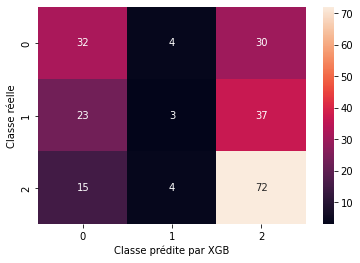

In [27]:
# Matrice de confusion et scores
y_pred_boost = boost.predict(X_test)
confusion_matrix = pd.crosstab(y_test,y_pred_boost, rownames = ['Classe réelle'], colnames = ['Classe prédite par XGB'])
sns.heatmap(confusion_matrix, annot = True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred_boost));

Meilleur score obtenu jusqu'ici

#Réduction de dimension - PCA

Test sur KNN

In [30]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

clf=KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors= 55, weights= 'distance')

pca = PCA(n_components = 0.9)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
clf.fit(X_train_pca, y_train)
print(clf.score(X_test_pca, y_test))

0.5045454545454545


In [31]:
print(pca.n_components_)

10


La réduction de dimension augmente le score du KNN en ne gardant que 10 composantes au lieu des 18 variables de départ et donne le meilleur résultat sur cet ensemble de variables.